<h1>Nintendo Wii remote controlled Graphical User Interface for CrazyFlie Drone</h1> <br>
AE483: Autonomous Systems, Fall 2021<br>
Erika Jarosch, George Petrov, Justin Roskamp, Kenneth Tochihara

# Magic Wand README

This project utilizes a Wii remote to plan the path of a drone.

## Description

An in-depth paragraph about your project and overview of use.

## Getting Started

### Dependencies

#### MacOS

* Required tools
    * Xcode command line tools
    * homebrew
    * Miniconda/Anaconda

Install the necessary tools using homebrew
```
brew install git-lfs
brew install libusb
brew tap PX4/homebrew-px4
brew install gcc-arm-none-eabi
```

Install the necessary Python packages using conda
```
conda install numpy scipy sympy matplotlib
pip install notebook
pip install cfclient
pip install cflib
pip install pybullet --no-cache-dir
pip install tk
pip install Pillow
```

### Download the code

Clone the firmware for drone
```
git clone --recursive https://github.com/tbretl/crazyflie-firmware.git
```

Clone control code from this repository
```
git clone https://github.com/ktt3/ae483-magic-wand.git
```

## Executing program

#### MacOS

Make the script executable (one time)
```
chmod +x run_macos.sh
```

Run the script in Terminal
```
./run_macos.sh
```

#### Windows

Run the script in Command Prompt
```
run_win.bat
```
## Authors

Erika Jarosch, George Petrov, Justin Roskamp, Kenneth Tochihara

## Acknowledgments

* [Professor Tim Bretl](https://aerospace.illinois.edu/directory/profile/tbretl)
* [AE 483 lab client codebase](https://github.com/tbretl/crazyflie-client)
* [AE 483 lab firmware codebase](https://github.com/tbretl/crazyflie-firmware.git)

Import Modules:

In [9]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d

# 1. Development of Code

### 1.1 GUI.py

The GUI allows for the abstractions of the Crazyflie client controller. The group created flight controller buttons to connect to the specified radio channel, clear drawing pad, run flight, and abort flight if necessary. The drawing pad created by this file allows the user to draw out a specified path, which then becomes normalized given the size of the flight arena and send to the drone as move commands.

### 1.2 client.py

:)

# 2. Run the GUI

#### Running the following box should generate the interface.
##### In particular, be sure to have followed each of the relevant steps under "Executing Program" in the README listed at the top of this notebook.

In [8]:
!./run

zsh:1: no such file or directory: ./run


# 3. Draw Image and Save Data 

Now connect the Nintendo Wii Remote to your computer.

The following cell contains a code snippet that details how the flight data is saved into the same directory. This can be found in the gui.py file. The "hardware_data" json file can then be loaded and parsed through in the following section.

```
        # save flight data to directory
        directory_name = "data/" + time.strftime("%Y%m%d-%H%M%S")
        os.mkdir(directory_name)
        os.replace("src/hardware_data.json", directory_name + "/hardware_data.json")
        im = ImageGrab.grab()
        im.save(directory_name + '/gui.png')

```

# 4. Load Data and Parse Results

Within the 'data' folder under this directory, prior flight tests and videos have been saved. Running the code from gui.py saves each flight test with a data and time stamp in this location. In the following cells, data from the groups most recent flight test will be loaded and parsed.

Film a video of your test flight on a hand-held phone device, then import and save the video as "hardware_video.mov" in the same directory as this notebook.

<video width="480" controls>
    <source src="data/20211212-172835-custom-ctrl-default-obsv/flight_video.mov">
</video>

#### Load flight test data.

Define a function to load data from a hardware flight test. This function loads and resamples the flight data at 100 Hz, using linear interpolation. It returns the resampled flight data in the form of a dictionary, where each item is a numpy array. If `only_in_flight=True`, then only data for which the desired position was positive (i.e., "trying to fly" rather than "sitting on the ground" data) will be returned

In [63]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=True):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)
        
    data.pop("start_time")
    data.pop("end_time")
    
    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define Symbolic variables

In [64]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

Now use the above function to load the data

In [76]:
data_custom_default = load_hardware_data(
    'data/20211212-172835-custom-ctrl-default-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)

data_custom_custom = load_hardware_data(
    'data/20211212-172705-custom-ctrl-custom-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)

data_default_default = load_hardware_data(
    'data/20211212-165749-default-ctrl-default-obsv/hardware_data.json',
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=False,
)


Parse flight test data.

In [77]:
# time
t = data['time']

# desired position (inputs)
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# custom controllers below

# state estimate from custom observer
o_x_custom = data_custom_custom['ae483log.o_x']
o_y_custom = data_custom_custom['ae483log.o_y']
o_z_custom = data_custom_custom['ae483log.o_z']

# state estimates from default observer
o_x_default = data_custom_default['stateEstimate.x']
o_y_default = data_custom_default['stateEstimate.y']
o_z_default = data_custom_default['stateEstimate.z']

# default controller below
# state estimate from default observer
o_x_def_controller = data_default_default['ae483log.o_x']
o_y_def_controller = data_default_default['ae483log.o_y']
o_z_def_controller = data_default_default['ae483log.o_z']

Display a plot of the drawn image alongside a plot of the observer output.

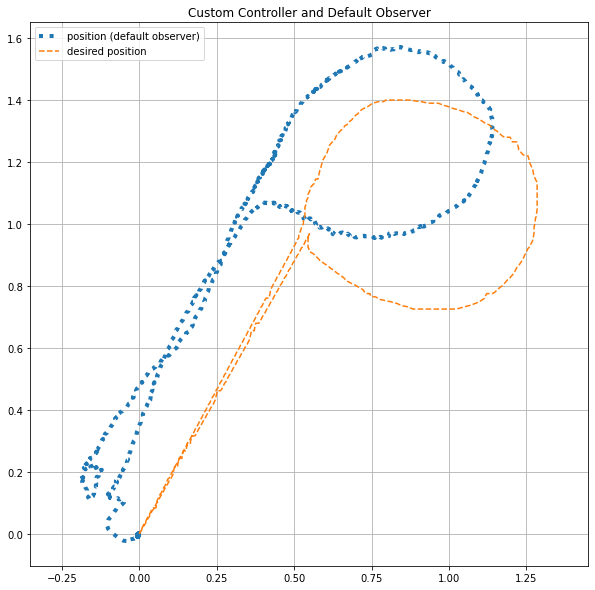

In [79]:
# custom, default
plt.figure(figsize=(10, 10))
plt.title("Custom Controller and Default Observer")
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

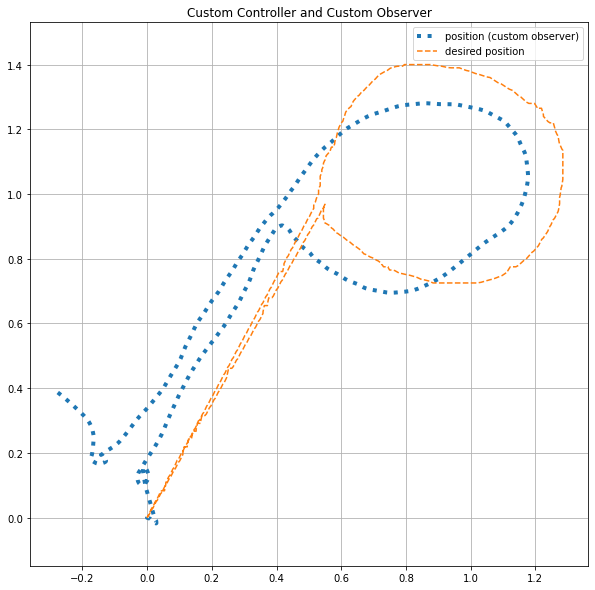

In [83]:
# custom, custom
plt.figure(figsize=(10, 10))
plt.title("Custom Controller and Custom Observer")
plt.plot(o_x_custom, o_y_custom, ':', label='position (custom observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

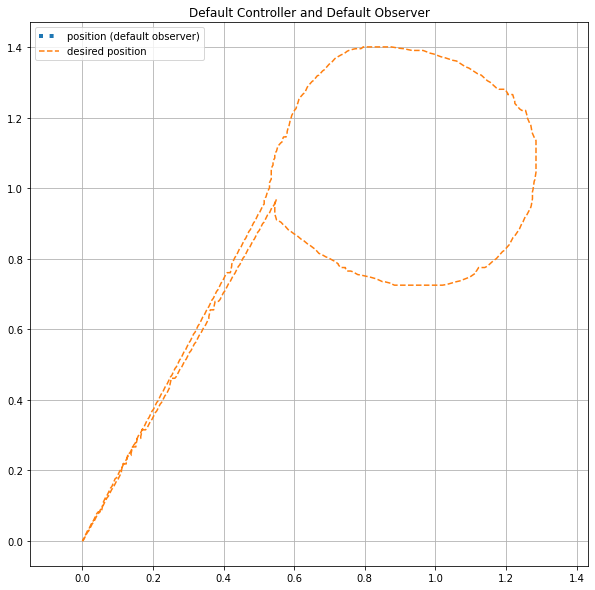

In [81]:
# default, default
plt.figure(figsize=(10, 10))
plt.title("Default Controller and Default Observer")
plt.plot(o_x_def_controller, o_y_def_controller, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

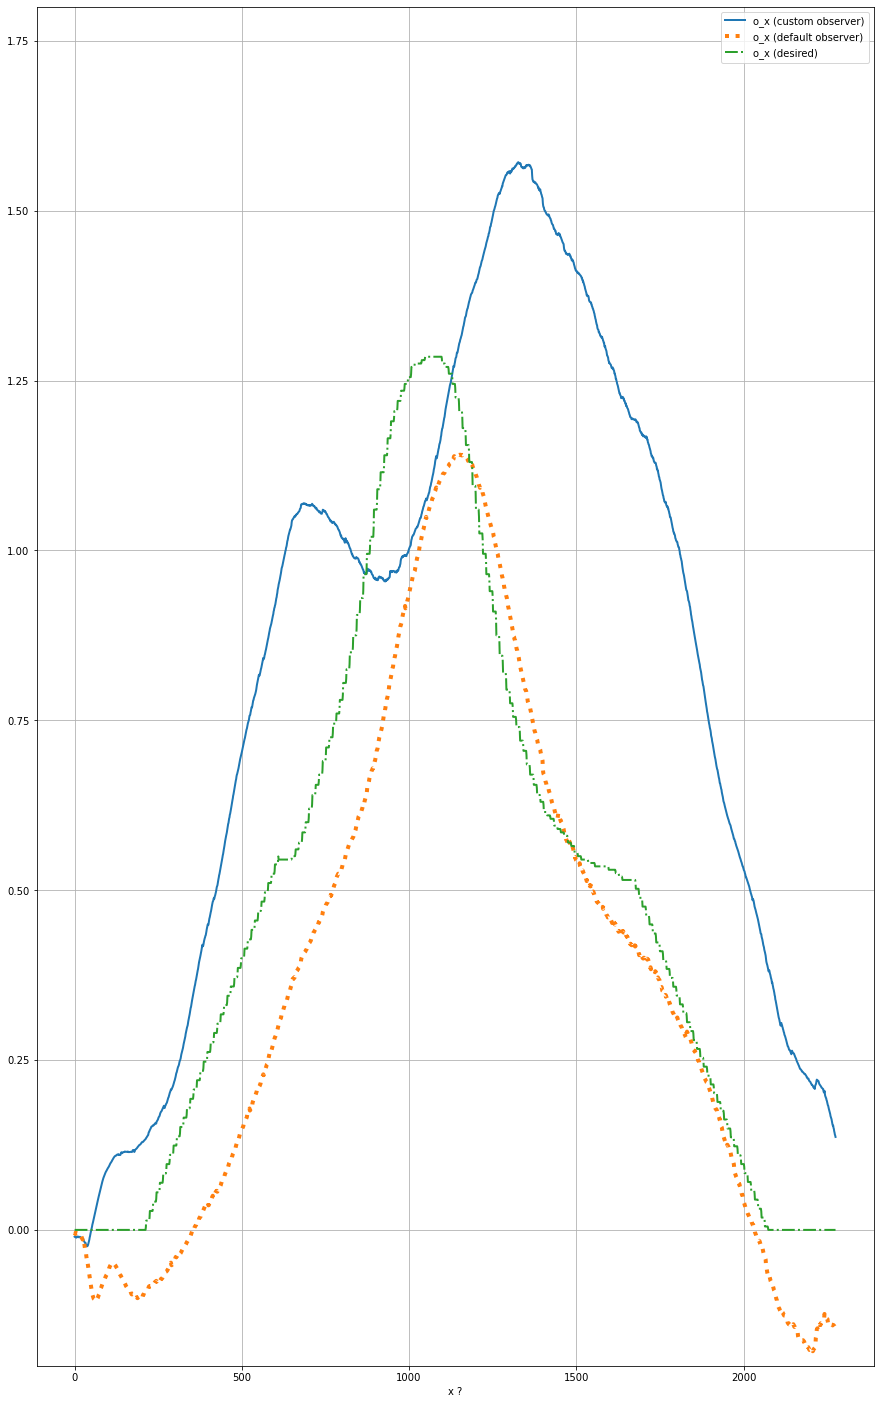

In [52]:
# custom, default
def observer_plot(s_default, s_custom, name, ax, s_des=None):
    ax.plot(s_custom, label=f'{name} (custom observer)', linewidth=2)
    # ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
    
    ax.plot(s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_huh) = plt.subplots(1, 1, figsize=(15, 25), sharex=True)

observer_plot(o_x_custom, o_y_custom, 'o_x', ax_o_huh, s_des=o_x_des)

ax_o_huh.set_xlabel('x ?')

ax_o_huh.set_ylim([-0.2, 1.8])


plt.show()

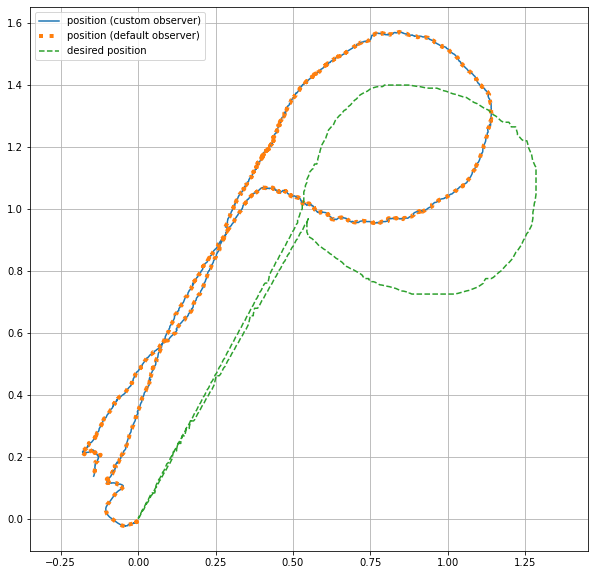

In [53]:
# custom, custom

plt.figure(figsize=(10, 10))
plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()